# FLEX scRNA pilot
## First clustering round
- Author: Kane Foster
- Date: 25/March/2025

Combine FLEX and 5' data, integrate, co-cluster

In [2]:
import os
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
adata_flex = sc.read('../out/single_cell_object/adata_clean.h5ad')
adata_5prime = sc.read('../out/single_cell_object/adata_5prime_clean.h5ad')

## Gene overalp

In [ ]:
!pip install matplotlib_venn

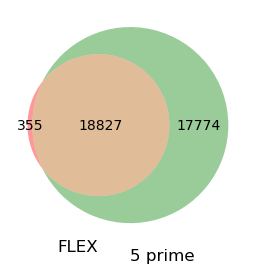

In [17]:
import matplotlib_venn as venn

set1 = set(adata_flex.var_names.to_list())
set2 = set(adata_5prime.var_names.to_list())
    
unique_to_set1 = len( set1 - set2 )
unique_to_set2 = len( set2 - set1 )
intersection = len( set1 & set2 )

plt.figure(figsize=(5,3))
venn.venn2(subsets=(unique_to_set1, intersection, unique_to_set2), set_labels=('\n\nFLEX', '\n5 prime'))
plt.show()

In [74]:
list(set1 - set2)[:10]

['H2BC9',
 'DELEC1',
 'ENSG00000284797',
 'SSU72L6',
 'DNAAF10',
 'PALM2AKAP2',
 'H3C6',
 'NHERF2',
 'ZNF722',
 'H1-3']

## Concatenate objects, attach md

In [27]:
adata = ad.concat(
    adatas = [ adata_flex, adata_5prime ],
    join='inner',
    merge='same',
    keys=['FLEX','5prime'],
    index_unique='-'
)
adata

AnnData object with n_obs × n_vars = 248290 × 17774
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample_id', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

In [75]:
sample_metadata = pd.read_csv('../data/sample_md.tsv',sep='\t').drop_duplicates()

In [55]:
adata.obs = adata.obs.reset_index().merge(sample_metadata, how="left", on='sample_id').set_index('index') #252,318

In [66]:
adata

AnnData object with n_obs × n_vars = 248290 × 17774
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample_id', 'leiden', 'pt_id', 'mod', 'tissue', 'sort'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

## Inter-modality comparison

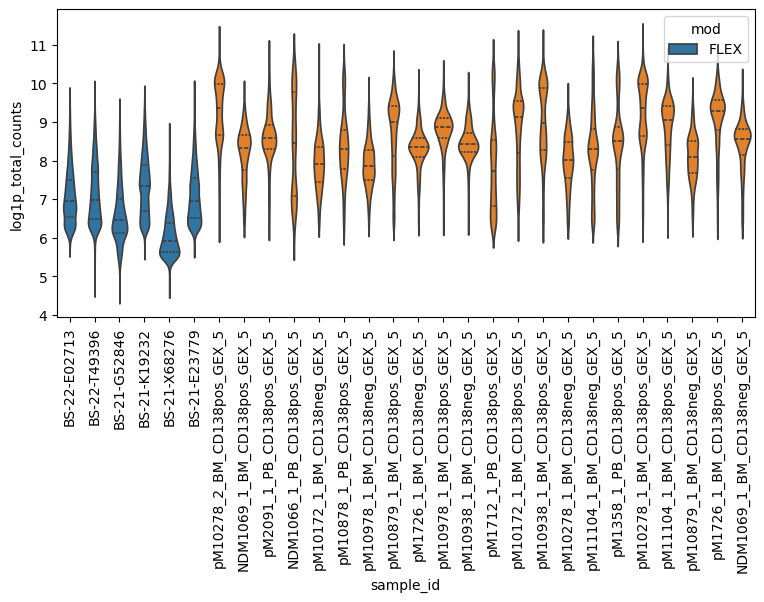

In [69]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.violinplot(data=adata.obs, x="sample_id", y="log1p_total_counts", hue="mod", inner="quart",ax=ax)
plt.xticks(rotation=90)
plt.show()

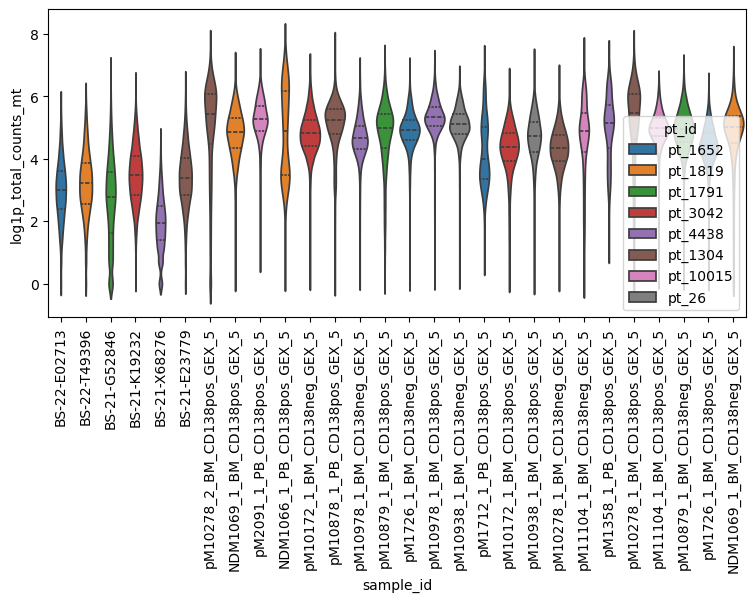

In [70]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.violinplot(data=adata.obs, x="sample_id", y="log1p_total_counts_mt", hue="pt_id", inner="quart",ax=ax)
plt.xticks(rotation=90)
plt.show()

## Jointly integrated and cluster

In [ ]:
#sc.tl.pca(adata,use_highly_variable=True,random_state=12345)

In [ ]:
# Batch correct PCs with Harmony
import harmonypy as hm
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, ['mod','sample_id'])

adata.obsm['X_pca_harmony_joint'] = np.transpose(ho.Z_corr)

sc.pp.neighbors(adata,n_pcs=50,random_state=12345,use_rep='X_pca_harmony') #no key as removed during concat

sc.tl.umap(adata,random_state=12345, key_added='umap_joint')

#sc.tl.leiden(adata, key_added='leiden_joint')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden0.5_joint')

In [86]:
adata

AnnData object with n_obs × n_vars = 248290 × 17774
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample_id', 'leiden', 'pt_id', 'mod', 'tissue', 'sort', 'leiden0.5_joint'
    uns: 'neighbors', 'umap_joint', 'leiden0.5_joint'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_pca_harmony_joint', 'umap_joint'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

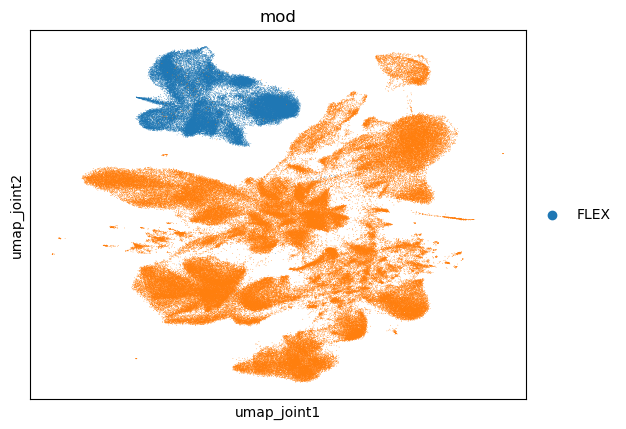

In [102]:
sc.pl.embedding(adata,basis='umap_joint',
    color=['mod'],
    size=1,ncols=1
)

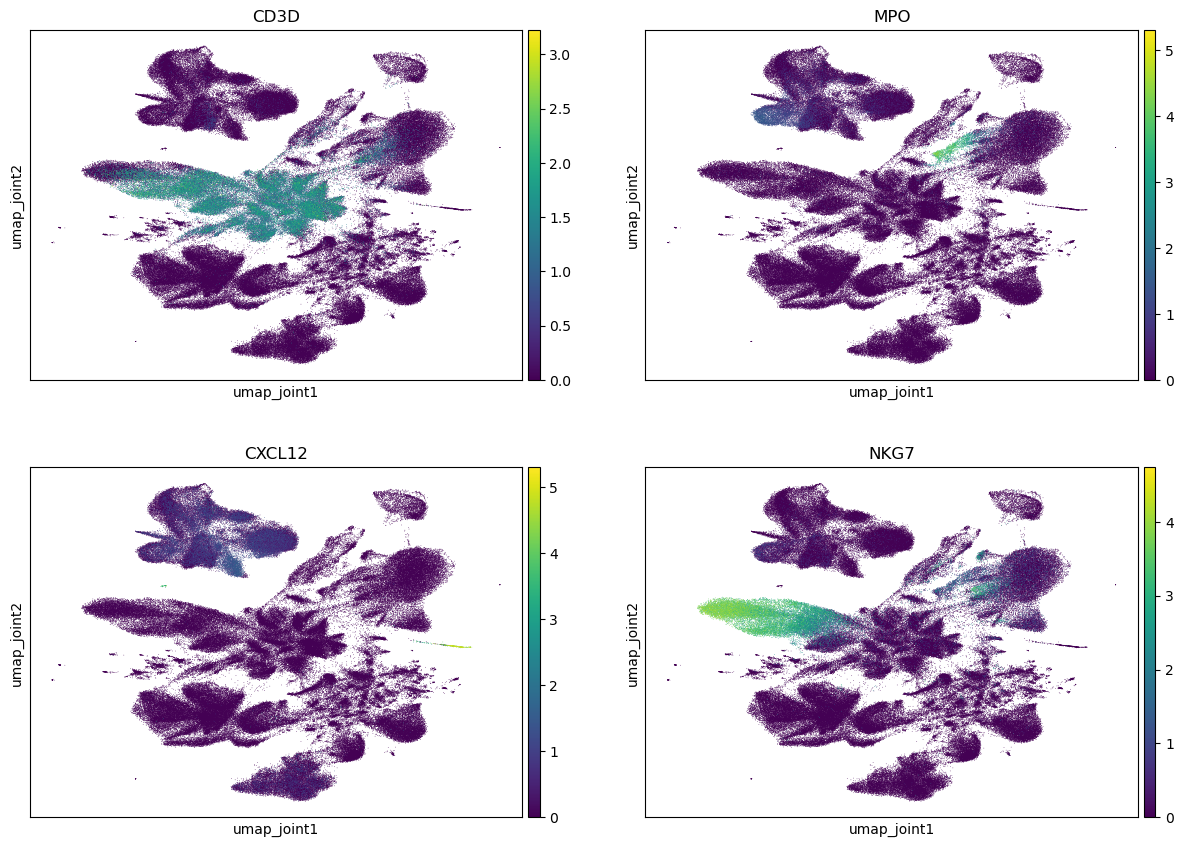

In [105]:
sc.pl.embedding(adata,basis='umap_joint',
    color=['CD3D','MPO','CXCL12','NKG7'],
    # Setting a smaller point size to get prevent overlap
    size=1,
    ncols=2
)

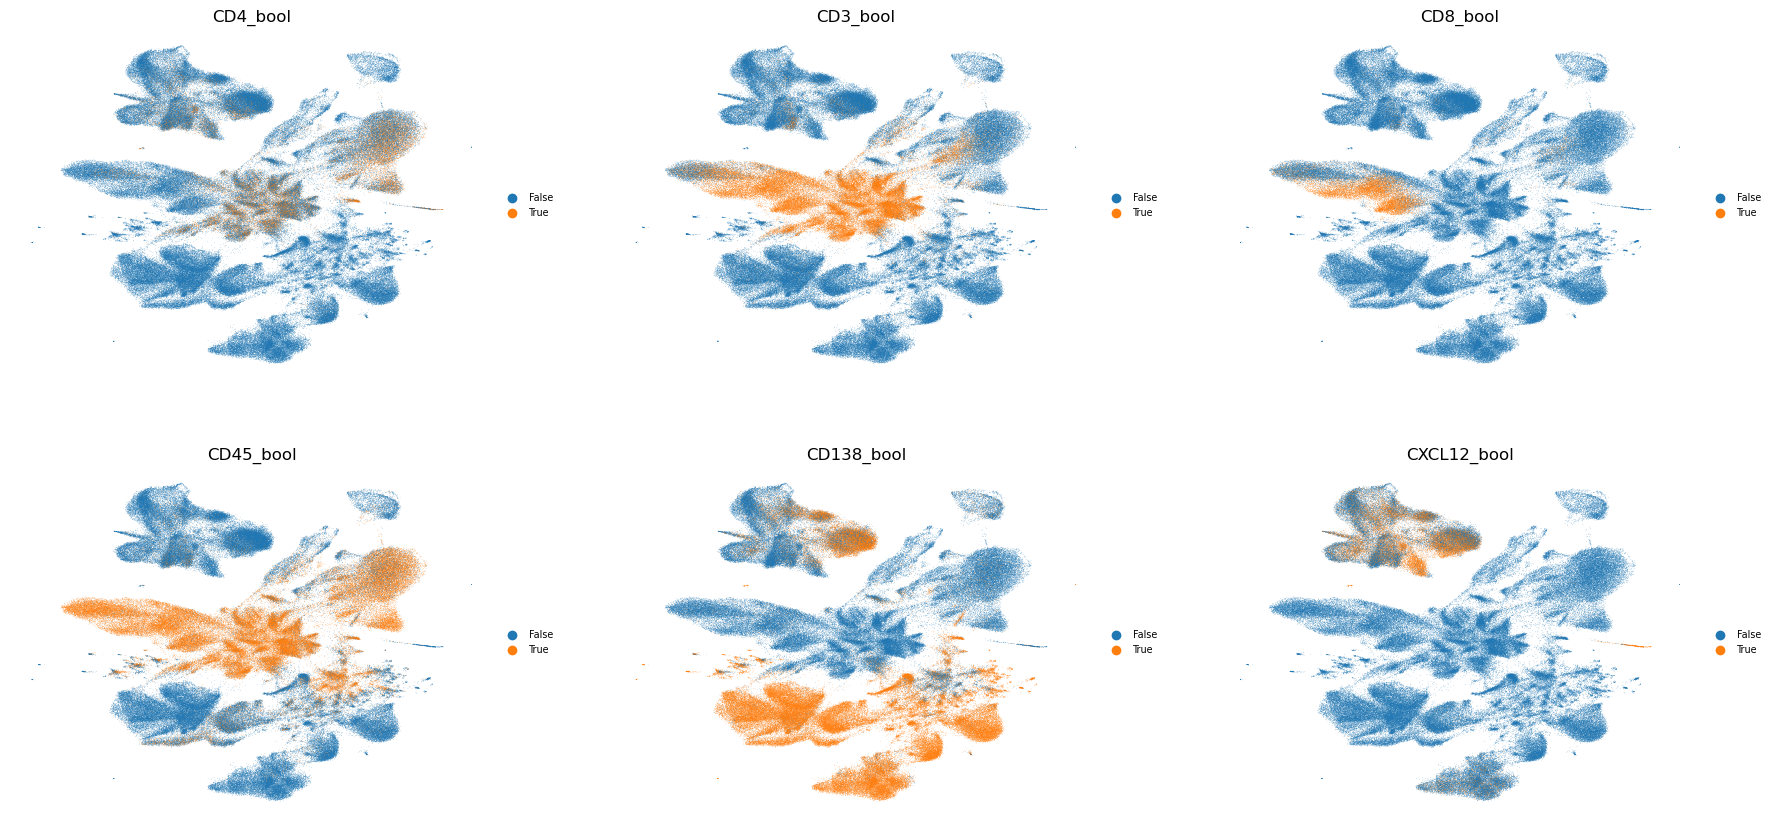

In [124]:
# marker +/-
gene_dicts = {'CD4':['CD4'], 'CD3':['CD3D','CD3E','CD3G'], 'CD8':['CD8A'],'CD45':['PTPRC'],'CD138':['MZB1'],'CXCL12':['CXCL12']}
for key,values in gene_dicts.items():
    X=adata[:,values].X.sum(axis=1)
    adata.obs[key+'_bool'] = np.array(np.array(X, dtype=bool), dtype=str)

sc.pl.embedding(adata, basis="umap_joint",frameon=False,ncols=3,color=[i+'_bool' for i in list(gene_dicts.keys())],
    legend_loc='right margin',legend_fontoutline=2,legend_fontsize='x-small')

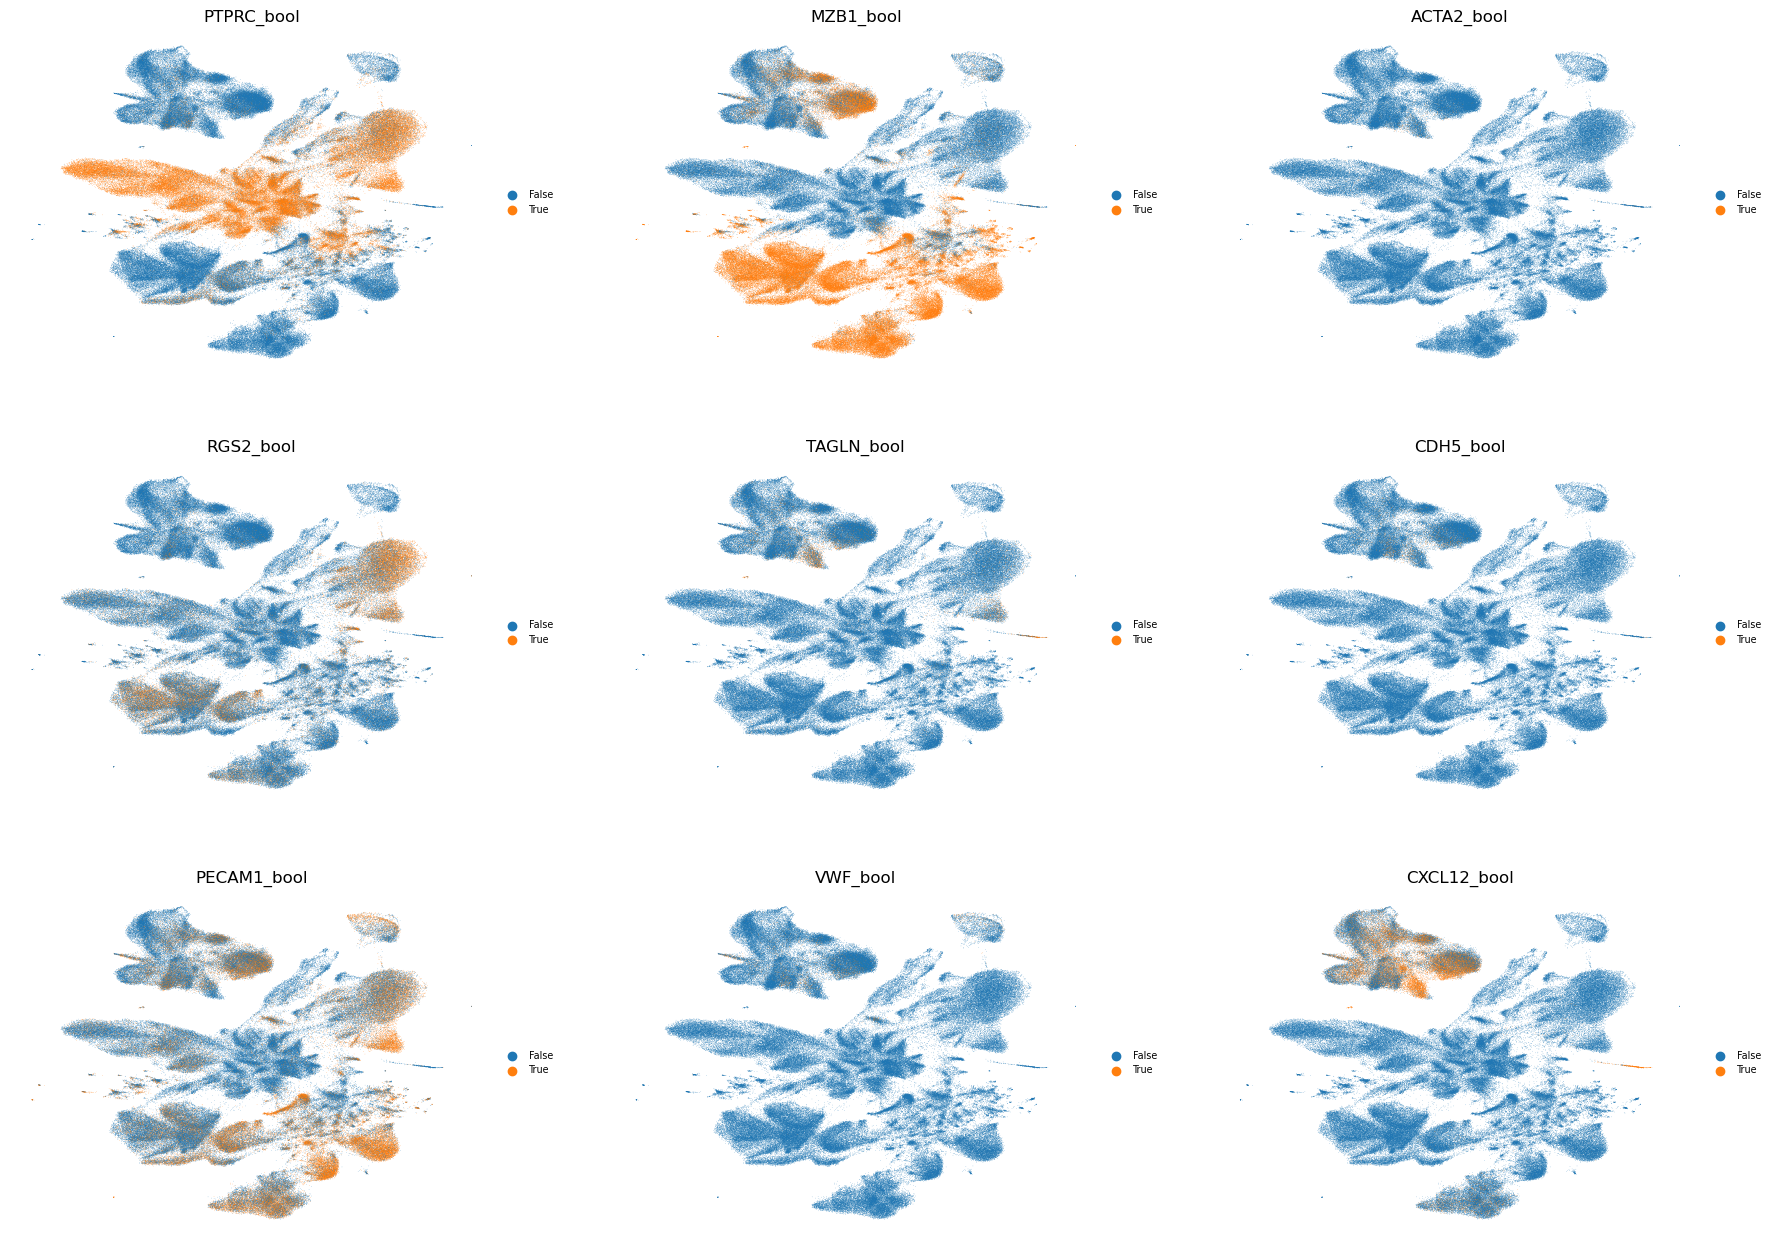

In [126]:
# Didn't look good re: expression
Bandyo_major = ['PTPRC','MZB1','ACTA2','RGS2','TAGLN','CDH5','PECAM1','VWF','CXCL12']

for g in Bandyo_major:
    X=adata[:,g].X.sum(axis=1)
    adata.obs[g+'_bool'] = np.array(np.array(X, dtype=bool), dtype=str)

sc.pl.embedding(adata, basis="umap_joint",frameon=False,ncols=3,color=[i+'_bool' for i in Bandyo_major],
    legend_loc='right margin',legend_fontoutline=2,legend_fontsize='x-small')

## Save

In [96]:
adata.write('../out/single_cell_object/adata_joint.h5ad')